In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../../latent_analysis/'))
sys.path.append(os.path.abspath('../../dPCA/python/'))
import json
from pathlib import Path
from utils import create_directory
from model import test
import plot as plot
import LTransform as LT
import numpy as np
import matplotlib.pyplot as plt

In [29]:
model_num = 1
phase = 2

model_name = "model{:02d}".format(model_num)
data_dir = create_directory(directory_name='try11')
log_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_log.json'))[0]
weight_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_weights'))[0]
cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_cfg.json'))[0]

In [3]:
from utils import calculate_lateral_deviation
from scipy.optimize import minimize

def lat_loss(theta):
    data = test(cfg_file,weight_file,ff_coefficient=0,is_channel=True,K=np.exp(theta[0]),B=-np.exp(theta[1]))
    _, _, _, opt = calculate_lateral_deviation(data['xy'], data['tg'], data['vel'])
    return np.mean(opt['max_lateral_dev'])

# find K and B such that max lateral deviation is minimized...
loss_before = lat_loss([-np.inf , -np.inf])

theta0 = [5,2]
theta = minimize(lat_loss,theta0,method='Nelder-Mead',options={'maxiter':10000,'disp':False})
loss_after = lat_loss(theta.x)

print(f'loss before: {loss_before}')
print(f'loss after: {loss_after}')
print(np.exp(theta.x))

#fig, ax  = plot.plot_simulations(xy=xy,target_xy=tg, vel=vel,figsize=(8,6))

loss before: 0.007032320834696293
loss after: 0.0012369269970804453
[1.77713282e+02 3.81561602e-02]


In [4]:
theta = theta.x
#theta = [ 5.1538208 , -0.12577515]


In [5]:
theta

array([ 5.18017147, -3.26606806])

In [30]:
np.exp([ 5.16412342,-2.60298069])
K=175
B=-0.07

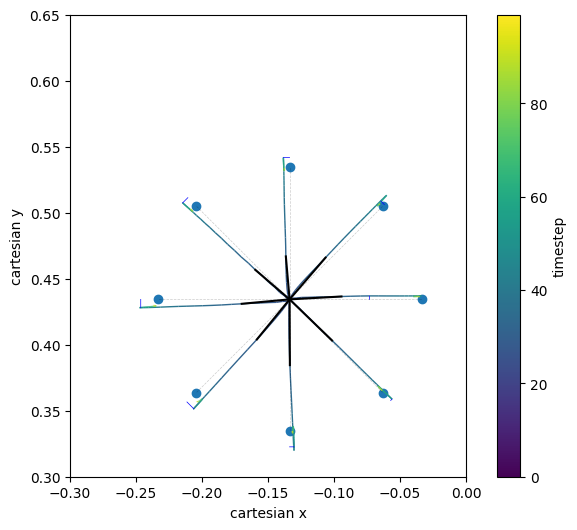

In [31]:

#%matplotlib widget
#%matplotlib qt
#%matplotlib inline
data = test(cfg_file,weight_file,ff_coefficient=0,is_channel=True,K=K,B=B)
fig, ax  = plot.plot_simulations(xy=data['xy'],target_xy=data['tg'], vel=data['vel'],figsize=(8,6))

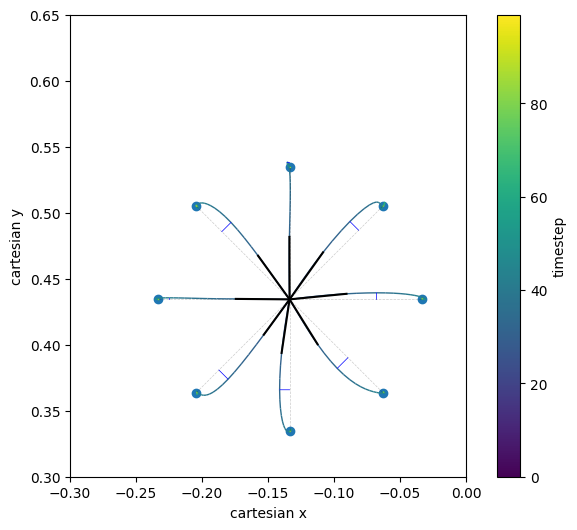

In [9]:
data = test(cfg_file,weight_file,ff_coefficient=0,is_channel=False,K=np.exp(theta[0]),B=theta[1])
fig, ax  = plot.plot_simulations(xy=data['xy'],target_xy=data['tg'], vel=data['vel'],figsize=(8,6))

In [32]:
endpoint2 = np.array(data['all_endpoint'])

In [24]:
endpoint

array([[[ 0.00000000e+00,  0.00000000e+00],
        [-1.96677874e-08,  5.92708439e-02],
        [ 4.29456115e-09, -5.52871451e-03],
        ...,
        [-1.84169036e-09,  5.03837317e-03],
        [ 8.34465030e-09, -2.00842991e-02],
        [-1.20280310e-08, -1.01637617e-02]],

       [[ 0.00000000e+00,  0.00000000e+00],
        [-3.77616584e-02,  3.77616659e-02],
        [-2.23503392e-02,  2.23503467e-02],
        ...,
        [-4.79030982e-02,  4.79030460e-02],
        [-4.87703755e-02,  4.87703755e-02],
        [-4.01856676e-02,  4.01856676e-02]],

       [[ 0.00000000e+00,  0.00000000e+00],
        [-1.62525214e-02,  6.01401551e-09],
        [-1.16649177e-03, -1.64448295e-08],
        ...,
        [ 1.55357439e-02, -2.08616258e-09],
        [ 1.84213445e-02,  6.01401551e-09],
        [ 2.78992224e-02, -4.17232515e-09]],

       ...,

       [[ 0.00000000e+00,  0.00000000e+00],
        [-3.77616622e-02,  3.77616659e-02],
        [-2.88307369e-02,  2.88307369e-02],
        ...,
     

In [25]:
np.linalg.norm(endpoint[0,:,:],axis=1).shape

(100,)

(<Figure size 1000x1000 with 8 Axes>,
 array([<Axes: ylabel='hidden act (au)'>, <Axes: ylabel='hidden act (au)'>,
        <Axes: ylabel='hidden act (au)'>, <Axes: ylabel='hidden act (au)'>,
        <Axes: ylabel='hidden act (au)'>, <Axes: ylabel='hidden act (au)'>,
        <Axes: ylabel='hidden act (au)'>, <Axes: ylabel='hidden act (au)'>],
       dtype=object))

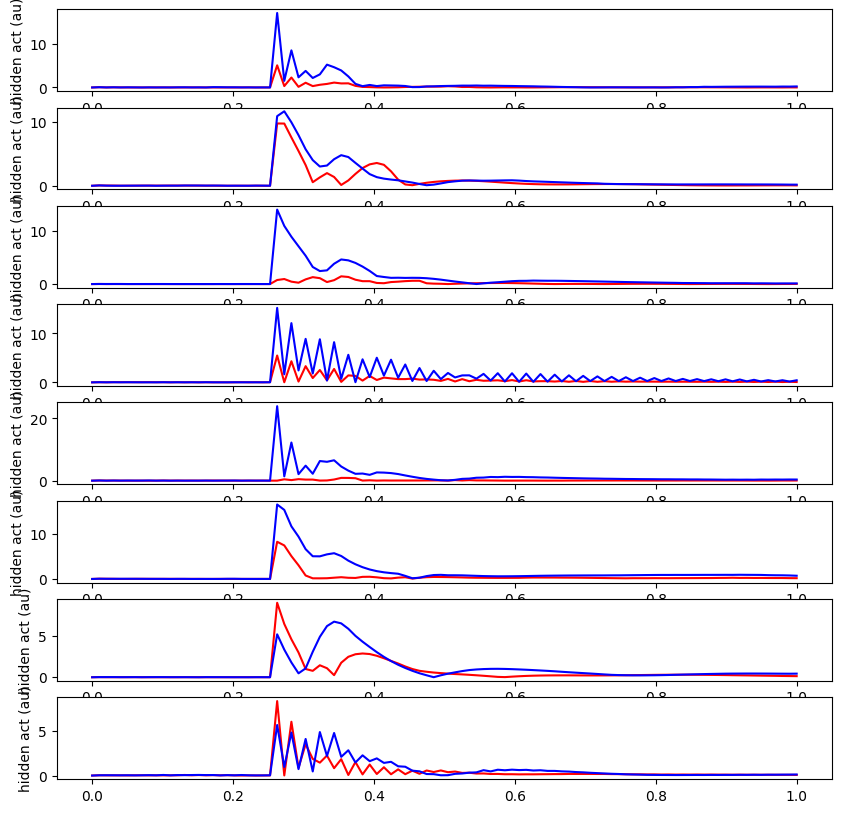

In [33]:
plot_force(endpoint,endpoint2)

In [27]:
def plot_force(endpoint1,endpoint2):
    fg, ax = plt.subplots(nrows=8,ncols=1,figsize=(10,10))

    x = np.linspace(0, 1, 100)

    for i in range(8):
        
        ax[i].plot(x,np.linalg.norm(endpoint1[i,:,:],axis=1),color='red',label='noFF')
        ax[i].plot(x,np.linalg.norm(endpoint2[i,:,:],axis=1),color='blue',label='noFF')
        
        ax[i].set_ylabel('Force [N]')
        ax[i].set_ylabel('hidden act (au)')

    return fg, ax

In [52]:
xy = np.array(xy)
vel = np.array(vel)

array([[[-23.391903 ,  76.01262  ],
        [-23.391644 ,  76.011734 ],
        [-23.391409 ,  76.010284 ],
        ...,
        [ -5.7741513,  76.090034 ],
        [ -5.7760234,  76.08677  ],
        [ -5.778983 ,  76.083496 ]],

       [[-23.391903 ,  76.01262  ],
        [-23.391644 ,  76.011734 ],
        [-23.391462 ,  76.01012  ],
        ...,
        [-11.002336 ,  88.3915   ],
        [-10.997623 ,  88.400116 ],
        [-10.9928665,  88.40951  ]],

       [[-23.391903 ,  76.01262  ],
        [-23.391644 ,  76.011734 ],
        [-23.391376 ,  76.01006  ],
        ...,
        [-23.29154  ,  93.49696  ],
        [-23.294748 ,  93.50185  ],
        [-23.296873 ,  93.508095 ]],

       ...,

       [[-23.391903 ,  76.01262  ],
        [-23.391644 ,  76.011734 ],
        [-23.391447 ,  76.0101   ],
        ...,
        [-35.689877 ,  63.664814 ],
        [-35.69772  ,  63.66363  ],
        [-35.705986 ,  63.661503 ]],

       [[-23.391903 ,  76.01262  ],
        [-23.391644 ,  76.0

In [6]:
model_num = 1
phase = 'growing_up'
directory_name = 'finetune1'

model_name = "model{:02d}".format(model_num)
data_dir = create_directory(directory_name=directory_name)
log_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_log.json'))[0]
weight_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_weights'))[0]
cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_cfg.json'))[0]

In [10]:
xy, tg, vel, all_hidden, all_muscle, all_force = test(cfg_file,weight_file,ff_coefficient=0,is_channel=False,K=np.exp(theta[0]),B=theta[1])

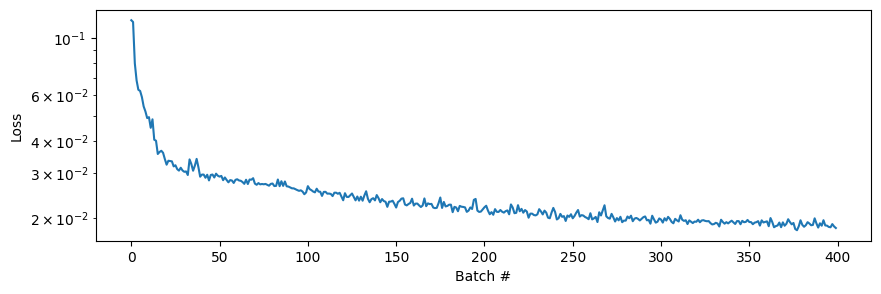

In [11]:
log = json.load(open(log_file,'r'))
fig,ax = plot.plot_training_log(log=log,loss_type='position')

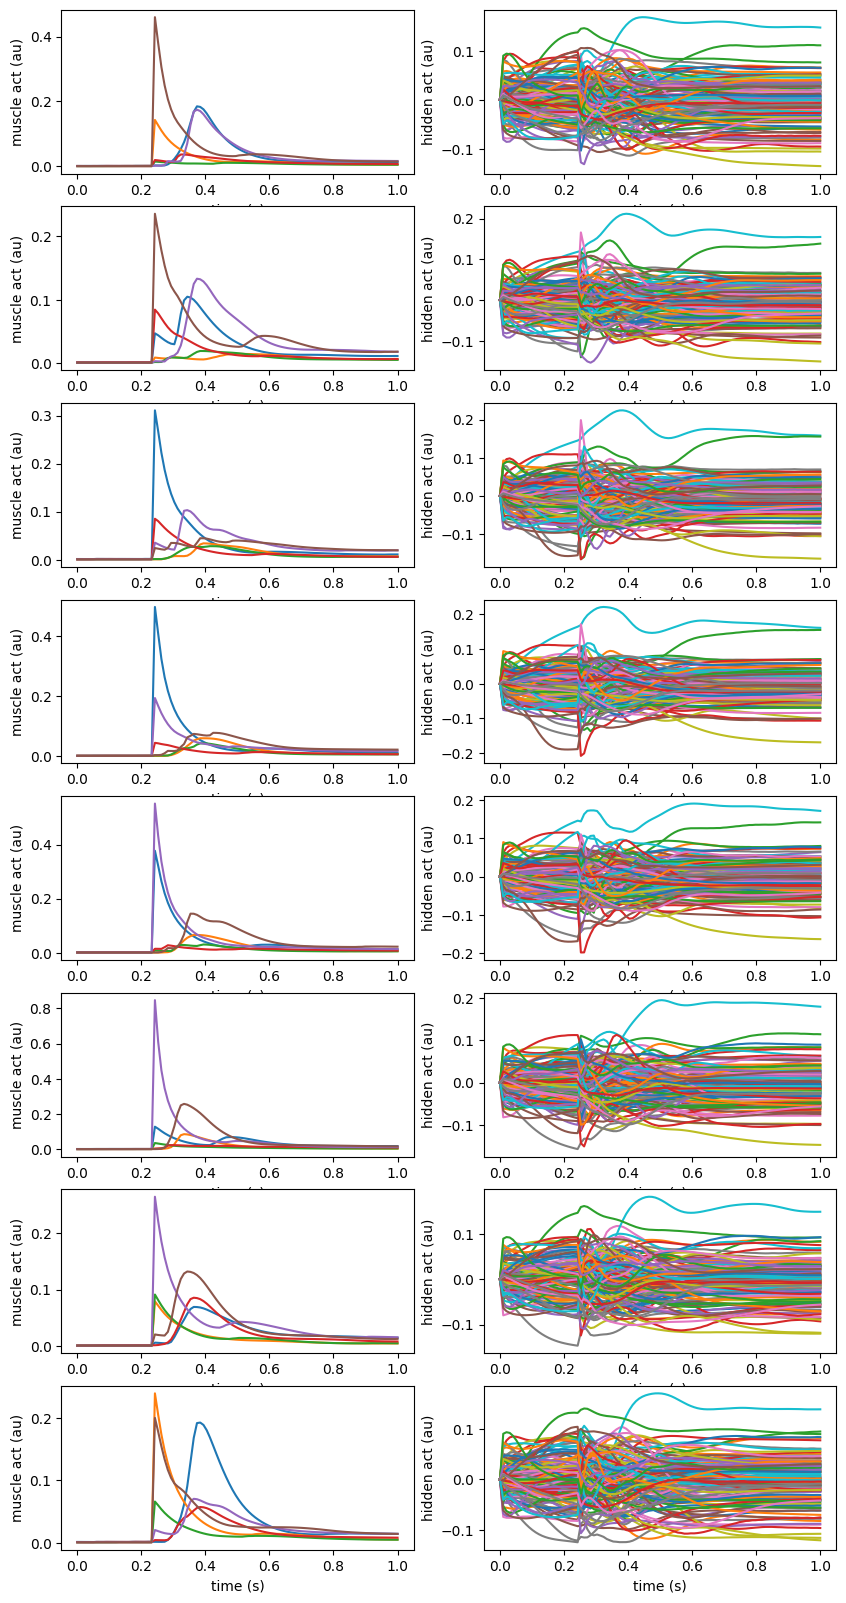

In [38]:
fig, ax = plot.plot_activation(all_hidden, all_muscle)
#fig.savefig(os.path.join(data_dir,'activations.png'),dpi=300)